In [337]:

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
from IPython.display import display_html
from networkx.algorithms import community
from collections import defaultdict




## 1. Introduction: Global nematode–mammal interactions (2018)


The nematode–mammal interaction network represents global relationships between parasitic nematodes and their mammalian hosts. The dataset, sourced from the helminthR package (2018), includes species-level information for both groups. Each node represents a nematode or a mammal species, and each edge shows a recorded interaction between them.

Analyzing this network helps reveal patterns of host–parasite connections, such as which mammals host the most parasites and which nematodes infect multiple species. Through network analysis techniques like centrality, modularity, and core analysis, we can identify key species, examine the structure of host–parasite communities, and gain insight into the ecological and biological processes that shape these global interactions.

## 2. Data Preparation 


The dataset was loaded from two CSV files: one containing the edges that represent interactions between nematodes and mammal species, and another with node metadata that describes each species. The metadata file was cleaned by removing extra spaces and symbols from column names to ensure consistent formatting. A new column named organism was created to classify each node as either a host or a parasite based on the is_host flag. This structured data provides the foundation for building and analyzing the nematode–mammal interaction network.

In [338]:
mamal_df = pd.read_csv(filepath_or_buffer="mammal_nematode/edges.csv")
metadata = pd.read_csv("mammal_nematode/nodes.csv")
metadata.columns = metadata.columns.str.strip().str.replace('#', '').str.replace(' ', '_')


In [339]:
animal_map = {1:"host",0:"parasite"}
metadata["organism"] =  metadata["is_host"].map(animal_map)

In [340]:
metadata.head()

,_index,name,full_name,locality,group,is_host,_pos,organism
0,0,Squalus blainville,"Proleptus robustus (van Beneden, 1871)",Northeast Atlantic,Nematoda,1,"array([32.67422356, 46.0460785 ])",host
1,1,Acanthocephaloides incrassatus,NaN,NaN,Teleostei,0,"array([39.44431659, 25.20409242])",parasite
2,2,Gobius bucchichi,Deretrema (Spinoderetrema) scorpaenicola Barto...,Western Mediterranean,Trematoda,1,"array([43.9399518 , 28.96108572])",host
3,3,Acanthocephaloides propinquus,NaN,NaN,Teleostei,0,"array([37.69593368, 27.68332545])",parasite
4,4,Gobius cruentatus,"Acanthocephaloides propinquus (Dujardin, 1845)",Atlantic Ocean,Acanthocephala,1,"array([30.49701772, 30.25827091])",host


In [341]:
host_nodes = metadata[metadata["organism"] == "host"]["_index"].to_list()
parasite_nodes = metadata[metadata["organism"] != "host"]["_index"].to_list()
GN = nx.Graph()
GN.add_nodes_from(host_nodes,bipartite = 1)
GN.add_nodes_from(parasite_nodes,bipartite = 0)
GN.add_edges_from(list(mamal_df.itertuples(index=False, name=None)))

In [342]:
bipartite.is_bipartite(GN)

True

In [343]:
node_colors = {}
for node,data in GN.nodes(data=True):
    data["name"] = (metadata[metadata["_index"] == node]).iloc[0]["name"]
    organism = (metadata[metadata["_index"] == node]).iloc[0]["organism"]
    data["organism"] = organism
    node_colors[node]= "tomato" if organism == "host" else "skyblue"
    # print(node,data)


In [356]:
#helper function
def display_side_by_side(dfs, titles=None):
    html_str = "<div style='display:flex;flex-flow:row nowrap;column-gap:20px'>"
    for df, title in zip(dfs, titles):
        html_str += f"""
        <div style="margin:10px">
            <h4 style="text-align:center">{title}</h4>
            {df.to_html()}
        </div>"""
    html_str += "</div>"

    display_html(html_str, raw=True)

def top_n_degrees(degree_dict: dict, n: int) -> pd.DataFrame:
    df = pd.DataFrame(list(degree_dict.items()), columns=["Node", "Degree"])
    df["Degree_(%)"] = (df["Degree"] / df["Degree"].sum()) * 100


    df = df.sort_values(by="Degree", ascending=False).head(n).reset_index(drop=True)
    return df.style.hide(axis="index")



def get_island_graph_components(G, threshold=3, remove_unconnected=False):
    strong_edges = [(u, v, d) for u, v, d in G.edges(data=True) if d["weight"] >= threshold]
    island_graph = nx.Graph()
    island_graph.add_edges_from(strong_edges)

    if remove_unconnected:
        island_graph.remove_nodes_from(list(nx.isolates(island_graph)))

    components = [island_graph.subgraph(c).copy() for c in nx.connected_components(island_graph)]
    components.sort(key=lambda x: x.number_of_nodes(), reverse=True)

    return island_graph, components


def plot_island_graph(G,threshold, node_size=400):
    if G.number_of_edges() == 0:
        fig, ax = plt.subplots()
        ax.text(0.5, 0.5, "No edges to plot", ha="center", va="center")
        ax.axis("off")
        return fig

    pos = nx.kamada_kawai_layout(G)
    weights = [d["weight"] for _, _, d in G.edges(data=True)]
    widths = [w / max(weights) * 4 for w in weights] if weights else 1

    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw(
        G,
        pos,
        node_color="skyblue",
        edge_color="gray",
        width=widths,
        node_size=node_size,
        with_labels=True,
        font_size=8,
        ax=ax
    )
    ax.axis("off")
    ax.set_title(f"Island Graph (edges weight ≥ {threshold})")
    


def analyze_island_metrics(G, top_n=10, graph_label="Island Graph"):
    avg_clustering = nx.average_clustering(G)
    avg_weighted_clustering = nx.average_clustering(G, weight="weight")
    density = nx.density(G)

    clustering_summary = pd.DataFrame(
        [["Average Clustering",avg_clustering],["Weighted Average Clustering", avg_weighted_clustering],["Density", density]],
        columns=["Metric Name","Result"]
    ).style.hide(axis="index")
    
    

    deg_centrality = nx.degree_centrality(G)
    bet_centrality = nx.betweenness_centrality(G)
    eig_centrality = nx.eigenvector_centrality(G)
    eig_centrality = nx.eigenvector_centrality(G)

    top_degree = top_n_degrees(deg_centrality, top_n)
    top_betweenness = top_n_degrees(bet_centrality, top_n)
    top_eigen = top_n_degrees(eig_centrality, top_n)

    display_side_by_side(
        [clustering_summary, top_degree, top_betweenness, top_eigen],
        [f"{graph_label} Metrics", "Degree Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
    )


def analyze_connectivity(G, graph_label="Graph"):
    articulation_points = list(nx.articulation_points(G))
    bridges = list(nx.bridges(G))

    summary = pd.DataFrame({
        "Metric": ["Articulation Points", "Bridges"],
        "Count": [len(articulation_points), len(bridges)],
        "Details": [
            articulation_points if articulation_points else "None",
            bridges if bridges else "None"
        ]
    })

    summary.index = [f"{graph_label} - {m}" for m in summary["Metric"]]
    # summary.drop(columns=["Metric"], inplace=True)

    return summary.style.hide(axis="index")



def summarize_core_numbers(G, top_n=None):
    core_numbers = nx.core_number(G)
    core_groups = defaultdict(list)

    for node, core_val in core_numbers.items():
        core_groups[core_val].append(node)

    # Sort by core number descending (deepest core first)
    core_items = sorted(core_groups.items(), reverse=True)

    if top_n is not None:
        core_items = core_items[:top_n]

    df = pd.DataFrame([
        {"Core_Number": k, "Node_Count": len(v), "Nodes": sorted(v)}
        for k, v in core_items
    ])

    return df

def summarize_component_counts(componentList, top_n=None):

    nodes =  []
    for comp in componentList:
        nodes.append(
            {
                "Component Count": len(comp),
                "Details": list(comp.nodes())
            }
            
            )

    df = pd.DataFrame(nodes).sort_values(by="Component Count",ascending=False).head(top_n)

    return df.style.hide(axis="index")



def plot_island_evolution(graph, weight_attr='weight', title='Island evolution across thresholds'):
    weights = [d.get(weight_attr, 0) for _, _, d in graph.edges(data=True)]
    if not weights:
        raise ValueError("Graph has no edges with the specified weight attribute.")
    
    min_w, max_w = int(min(weights)), int(max(weights))
    thresholds = range(min_w, max_w + 1)
    edges_count, comps_count, largest_size = [], [], []

    for t in thresholds:
        sub_edges = [(u, v) for u, v, d in graph.edges(data=True) if d.get(weight_attr, 0) >= t]
        subG = graph.edge_subgraph(sub_edges).copy()
        edges_count.append(subG.number_of_edges())
        comps = list(nx.connected_components(subG))
        comps_count.append(len(comps))
        largest_size.append(max((len(c) for c in comps), default=0))

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, edges_count, label="Edges remaining")
    plt.plot(thresholds, comps_count, label="Number of islands")
    plt.plot(thresholds, largest_size, label="Largest island size")
    plt.xlabel("Threshold (minimum edge weight)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()


## 3. Analysis

The network contains 30,516 nodes, representing both mammal hosts and nematode parasites. It forms a bipartite structure, where connections occur only between the two groups, linking parasites to their corresponding hosts. This structure makes it possible to explore how parasites are distributed among mammal species and to identify hosts that share similar parasites. Network analysis techniques such as degree, betweenness, and eigenvector centrality were applied to measure the importance of each species and to detect key nodes that contribute to the overall connectivity of the network.

In [345]:
len(GN.nodes())

30516

### 3.1 Host Organism

For the host organism, the Island method was applied to examine how connectivity changes as weaker links are removed. This approach helps identify clusters of mammal species that remain strongly connected through shared parasites, revealing the core structure of the host network.

In [ ]:

host_graph = bipartite.weighted_projected_graph(GN,set(host_nodes))
weights = nx.get_edge_attributes(host_graph, 'weight')
max_weight = max(weights.values())

In [355]:

max_weight

76

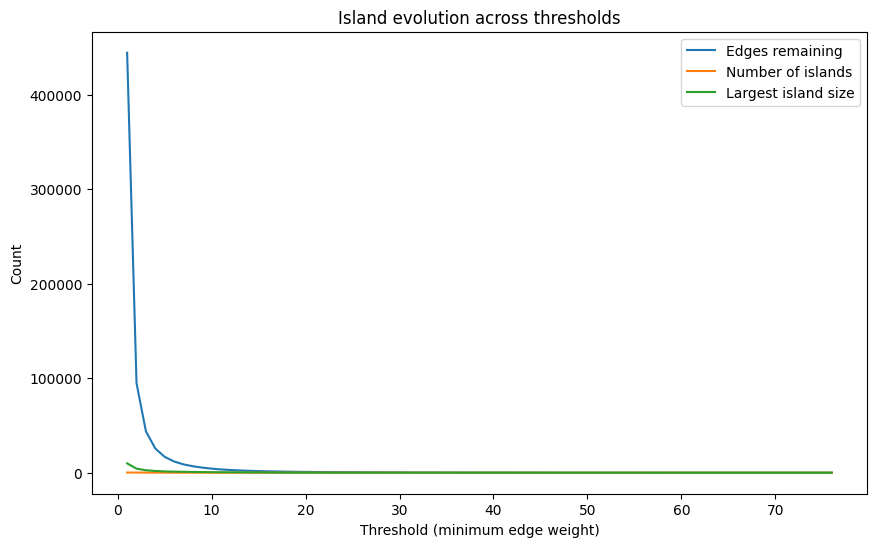

In [357]:
plot_island_evolution(host_graph)

This plot shows the evolution of the host network across different edge-weight thresholds using the Island method. The blue line represents the number of edges remaining, the orange line shows the number of islands (connected components), and the green line indicates the size of the largest island.

At the lower thresholds, the number of edges is very high, meaning that most connections are included. As the threshold increases, weaker edges are removed, and the number of edges drops sharply around the early range (below threshold 10). After this point, the curve flattens, indicating that only strong relationships remain and additional threshold increases no longer remove many connections.

The orange and green lines remain almost flat, showing that the number of islands and the largest island size change very little across thresholds. This suggests that the host network is highly cohesive, with a strong core of hosts that stay connected even as weaker links are removed. The stability of both lines indicates that weak edges play a limited structural role, and the overall connectivity is maintained by a small number of strong, consistent relationships among the host species.

In [349]:
host_graph_10, comps10 = get_island_graph_components(host_graph, threshold=10, remove_unconnected=True)
host_graph_10_comp = comps10[0]

host_graph_5, comps5 = get_island_graph_components(host_graph, threshold=5, remove_unconnected=True)
host_graph_5_comp = comps5[0]

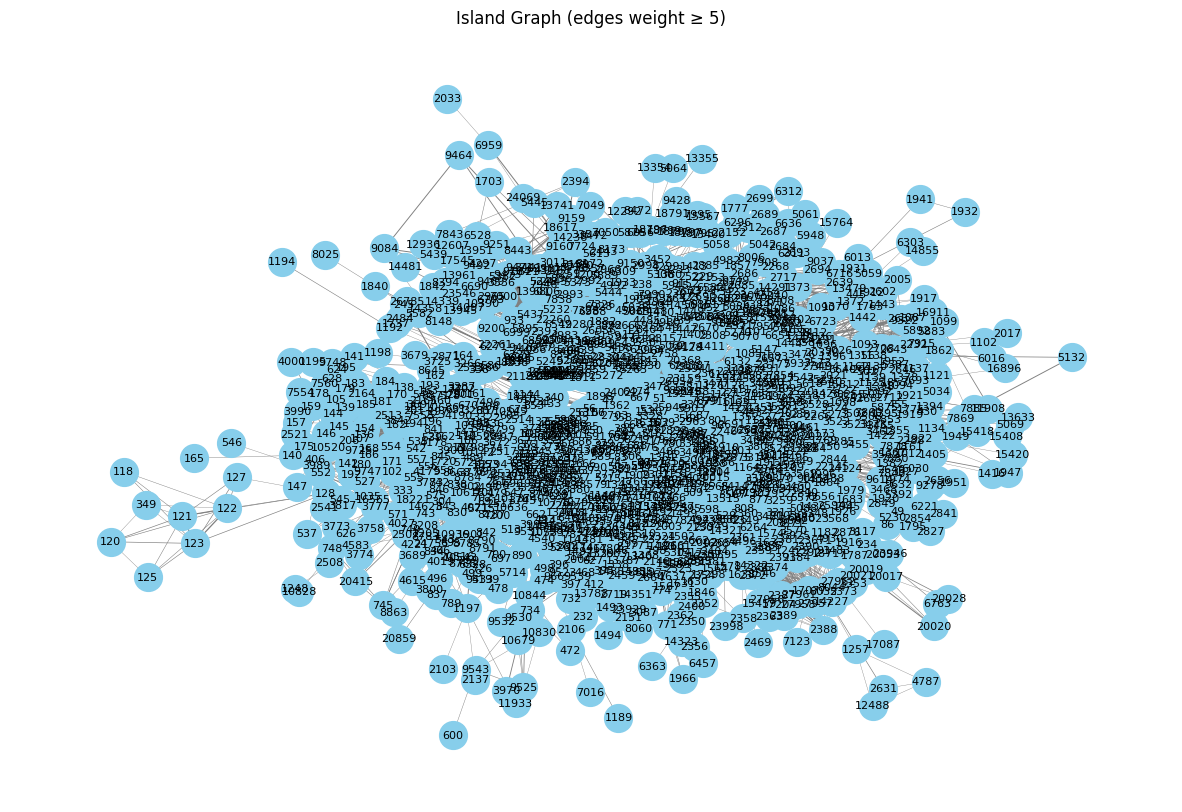

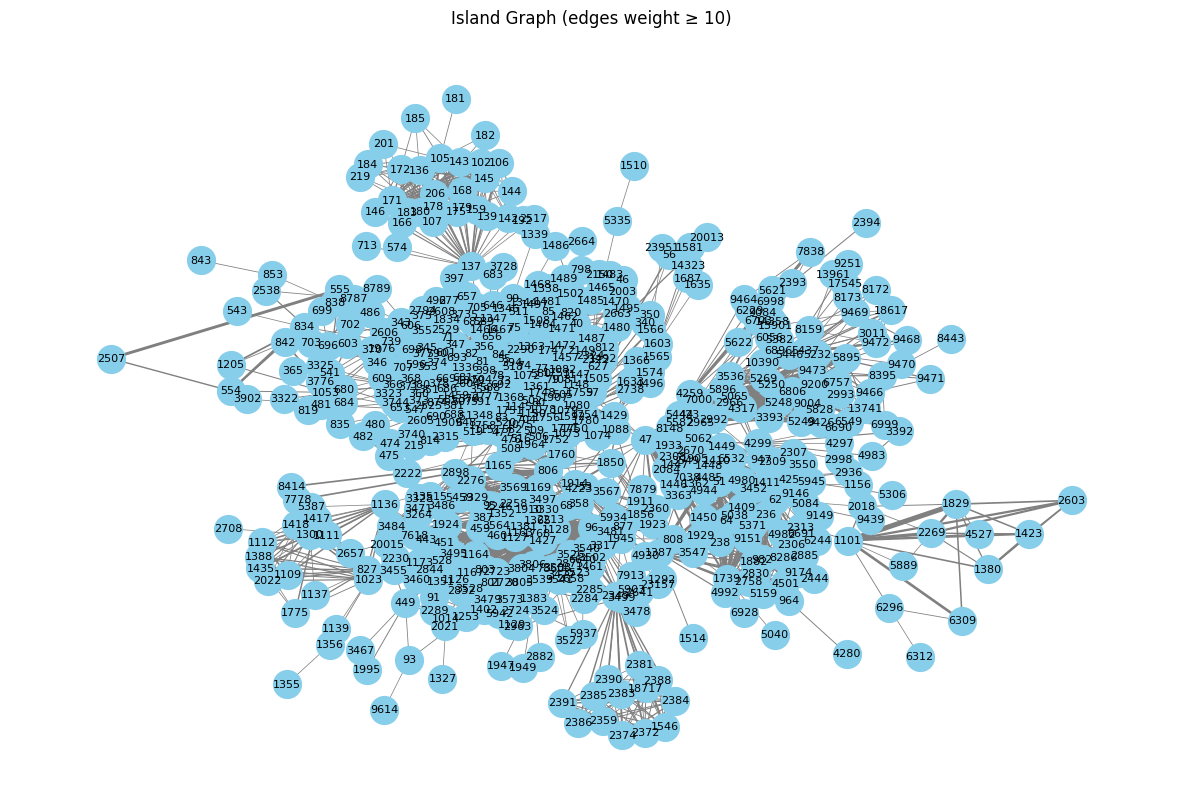

In [350]:


plot_island_graph(comps5[0],5)
plot_island_graph(comps10[0],10)

When comparing the two island graphs, the network at a threshold of 5 shows a large, dense core where most host species remain connected, indicating that many medium-strength interactions still hold the network together. At a higher threshold of 10, the network becomes more fragmented, breaking into several smaller clusters of tightly connected hosts. This shift suggests that while the overall host network is cohesive, only a few strong relationships form stable, well-defined groups once weaker connections are removed.

#### Island Metrics and Centrality Metrics

In [351]:
analyze_island_metrics(host_graph_5_comp, top_n=10, graph_label="Island ≥5")

analyze_island_metrics(host_graph_10_comp, top_n=10, graph_label="Island ≥10")




Island ≥5 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.666582 
 
 
 Weighted Average Clustering 
 0.074516 
 
 
 Density 
 0.017051 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 47 
 0.174511 
 0.740581 
 
 
 519 
 0.160029 
 0.679122 
 
 
 398 
 0.147719 
 0.626882 
 
 
 73 
 0.145547 
 0.617663 
 
 
 80 
 0.137581 
 0.583861 
 
 
 356 
 0.137581 
 0.583861 
 
 
 504 
 0.135409 
 0.574642 
 
 
 379 
 0.132513 
 0.562350 
 
 
 74 
 0.130340 
 0.553131 
 
 
 692 
 0.128892 
 0.546985 
 
 
 

 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 47 
 0.352586 
 14.080694 
 
 
 806 
 0.075425 
 3.012143 
 
 
 1080 
 0.069951 
 2.793529 
 
 
 2276 
 0.069351 
 2.769572 
 
 
 96 
 0.067580 
 2.698820 
 
 
 137 
 0.063373 
 2.530834 
 
 
 1914 
 0.046025 
 1.838013 
 
 
 739 
 0.045417 
 1.813760 
 
 
 519 
 0.044230 
 1.766337 
 
 
 62 
 0.035779 
 1.428836 
 
 
 

 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 73 
 0.143559 
 0.946948 
 
 
 398 
 0.141554 
 0.933727 
 
 
 519 
 0.141505 
 0.933398 
 
 
 692 
 0.137043 
 0.903972 
 
 
 504 
 0.134189 
 0.885144 
 
 
 379 
 0.132338 
 0.872936 
 
 
 356 
 0.127402 
 0.840374 
 
 
 74 
 0.125703 
 0.829165 
 
 
 378 
 0.119983 
 0.791439 
 
 
 82 
 0.117211 
 0.773153

Island ≥10 Metrics 
 
 
 
 
 Metric Name 
 Result 
 
 
 
 
 Average Clustering 
 0.659819 
 
 
 Weighted Average Clustering 
 0.139759 
 
 
 Density 
 0.023249 
 
 
 

 
 
 Degree Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 80 
 0.164129 
 1.192525 
 
 
 398 
 0.148900 
 1.081879 
 
 
 73 
 0.143824 
 1.044996 
 
 
 55 
 0.143824 
 1.044996 
 
 
 519 
 0.140440 
 1.020408 
 
 
 520 
 0.135364 
 0.983526 
 
 
 692 
 0.130288 
 0.946644 
 
 
 356 
 0.130288 
 0.946644 
 
 
 379 
 0.128596 
 0.934350 
 
 
 394 
 0.120135 
 0.872879 
 
 
 

 
 
 Betweenness Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 47 
 0.410507 
 13.243407 
 
 
 1080 
 0.195843 
 6.318100 
 
 
 806 
 0.177040 
 5.711497 
 
 
 356 
 0.169174 
 5.457727 
 
 
 96 
 0.131427 
 4.239966 
 
 
 137 
 0.103361 
 3.334545 
 
 
 519 
 0.095288 
 3.074104 
 
 
 2276 
 0.092768 
 2.992787 
 
 
 57 
 0.091379 
 2.947991 
 
 
 80 
 0.070861 
 2.286053 
 
 
 

 
 
 Eigenvector Centrality 
 
 
 
 
 Node 
 Degree 
 Degree_(%) 
 
 
 
 
 398 
 0.191043 
 1.828779 
 
 
 80 
 0.187484 
 1.794707 
 
 
 519 
 0.183341 
 1.755053 
 
 
 73 
 0.180357 
 1.726486 
 
 
 55 
 0.179490 
 1.718193 
 
 
 520 
 0.175941 
 1.684212 
 
 
 504 
 0.170730 
 1.634332 
 
 
 692 
 0.170423 
 1.631392 
 
 
 394 
 0.161725 
 1.548132 
 
 
 518 
 0.152668 
 1.461429

At a threshold of 5, the network shows a moderately cohesive structure with an average clustering coefficient of 0.67 and a density of 0.017, meaning that hosts are well connected but the network is not overly dense. Node 47 stands out as the most central in both degree and betweenness, suggesting it plays an important role in linking different parts of the network. Nodes 519, 398, and 73 also rank high in degree and eigenvector centrality, showing that they are not only well connected but also linked to other influential nodes. Overall, several hosts share high centrality values, indicating that influence in the network is distributed among multiple key species rather than dominated by one.

At a threshold of 10, the network becomes smaller and more compact but stays cohesive. The average clustering coefficient slightly decreases to 0.66, while density increases to 0.023, showing that the remaining connections are concentrated within tightly linked groups. Node 47 continues to act as the main bridge, with the highest betweenness centrality, while nodes 398, 80, and 519 remain highly ranked in both degree and eigenvector centrality. These nodes continue to anchor the structure of the network even as weaker links are removed, forming stable cores that keep it connected.

Comparing both thresholds shows how the network evolves as weaker connections are filtered out. At 5, the structure is broad and well connected, supported by many medium-strength links. By 10, only the strongest ties remain, forming smaller but denser clusters. Despite this shift, nodes 47, 398, 519, and 73 consistently appear as central, showing that they make up the stable backbone of the host network. This suggests that while weaker connections help maintain overall cohesion, a small group of strongly connected hosts holds the network together.

#### Circulation Points and Bridges

In [352]:
connectivity_10 = analyze_connectivity(host_graph_10_comp, graph_label="Island ≥10")
connectivity_5 = analyze_connectivity(host_graph_5_comp, graph_label="Island ≥5")

display_side_by_side([connectivity_5,connectivity_10],["Island ≥5","Island ≥10"])

Metric,Count,Details
Articulation Points,104,"[731, 208, 1922, 1383, 20030, 445, 1487, 2003, 1182, 8035, 2373, 2232, 9026, 1367, 1395, 1388, 2708, 5017, 1136, 2875, 23941, 3568, 93, 1931, 6651, 449, 1023, 2649, 7913, 1373, 2018, 2307, 2306, 5306, 5159, 1371, 6959, 1200, 6450, 22261, 5437, 18796, 5934, 3317, 1914, 1101, 1411, 947, 238, 236, 1127, 1638, 1898, 1603, 1846, 1592, 1566, 2538, 140, 3672, 842, 834, 4583, 555, 128, 552, 1053, 853, 838, 631, 626, 739, 1080, 96, 7555, 603, 597, 806, 507, 3745, 486, 9543, 9531, 471, 398, 4178, 20516, 375, 374, 368, 336, 4188, 106, 351, 1192, 245, 1197, 1186, 2106, 4540, 47, 1844, 57, 5]"
Bridges,151,"[(5, 498), (57, 164), (351, 3702), (368, 3287), (374, 3697), (375, 20516), (398, 1144), (398, 1827), (471, 3970), (486, 496), (486, 4019), (507, 9539), (603, 7555), (739, 4179), (739, 18221), (739, 3689), (1080, 5589), (1080, 1567), (1080, 6283), (1080, 15279), (3745, 499), (3745, 4199), (731, 232), (731, 732), (731, 966), (806, 3313), (806, 3483), (1487, 8060), (2003, 2151), (47, 8238), (47, 1844), (47, 19443), (47, 5414), (47, 5690), (47, 22541), (47, 6273), (47, 14489), (47, 14632), (47, 6905), (47, 24087), (47, 24129), (47, 24166), (47, 24186), (47, 24234), (47, 8133), (96, 5488), (96, 1979), (236, 17826), (236, 24191), (238, 12292), (238, 8472), (336, 8871), (853, 3679), (853, 3725), (947, 2443), (1127, 3584), (1186, 2484), (1411, 2268), (1411, 5042), (1411, 7908), (1411, 8006), (1566, 23998), (1592, 14351), (1592, 23929), (1603, 1683), (1603, 1846), (1844, 1840), (1898, 6328), (1914, 6802), (1914, 3348), (1914, 1916), (2018, 7724), (2018, 9159), (2649, 5576), (2649, 6034), (3317, 20370), (5159, 9184), (5437, 5439), (22261, 26785), (5934, 7915), (6450, 14339), (23941, 14291), (7913, 25229), (49, 449), (449, 5230), (449, 2854), (2875, 2876), (1101, 9037), (1136, 1853), (5306, 9428), (1371, 5061), (2307, 7995), (93, 86), (4188, 10543), (2538, 24755), (1053, 4221), (3672, 571), (4540, 2106), (6651, 1931), (1023, 1012), (1023, 1161), (1023, 2288), (1023, 1405), (1383, 6030), (1383, 1951), (106, 16565), (140, 165), (208, 3353), (2306, 5948), (245, 8025), (1192, 1194), (838, 3758), (552, 546), (597, 3800), (631, 628), (4178, 10520), (20516, 20859), (842, 789), (9531, 9532), (445, 14855), (445, 6303), (2232, 2017), (555, 2541), (834, 8863), (4583, 1248), (626, 10828), (600, 9543), (7555, 7554), (7555, 7560), (20030, 20021), (1388, 1795), (1395, 5069), (2708, 1102), (2708, 6016), (1367, 1416), (9026, 16911), (1638, 2469), (1373, 15764), (3568, 6763), (1182, 7123), (1197, 2103), (1197, 2137), (1197, 11933), (1189, 2106), (2106, 7016), (6959, 2033), (5017, 11908), (1922, 15420), (2373, 17087), (1846, 6363), (1846, 6457)]"
Metric,Count,Details
Articulation Points,62,"[508, 3744, 374, 481, 834, 853, 838, 739, 366, 345, 1566, 1603, 1760, 3806, 1924, 460, 1014, 93, 449, 1300, 1023, 1356, 1383, 5934, 20015, 387, 2349, 806, 96, 6296, 2393, 423, 8395, 5437, 5896, 7000, 3536, 425, 1739, 1411, 1387, 238, 964, 4299, 62, 4259, 47, 1080, 99, 394, 5335, 1465, 1457, 77, 547, 74, 379, 57, 105, 137, 356, 820]"
Bridges,85,"[(356, 137), (356, 683), (356, 3728), (379, 480), (547, 835), (74, 1468), (77, 1502), (820, 2664), (1457, 1470), (1457, 1483), (1457, 1495), (1457, 2003), (47, 4259), (47, 5444), (47, 5582), (47, 8148), (57, 350), (62, 9439), (96, 2641), (96, 3478), (238, 6928), (423, 2393), (425, 5306), (806, 4223), (806, 3481), (1080, 2738), (1387, 1514), (1411, 1156), (1739, 5040), (3536, 5621), (3536, 6998), (4259, 6229), (4299, 2998), (4299, 4297), (4299, 6690), (5896, 6703), (5934, 23157), (7000, 5622), (394, 397), (508, 2222), (374, 486), (99, 1339), (1465, 5335), (93, 9614), (449, 3467), (449, 1995), (387, 20015), (460, 1402), (460, 2832), (460, 5942), (1383, 1947), (1383, 1949), (3806, 2882), (1924, 2657), (105, 181), (137, 192), (137, 2517), (137, 574), (137, 713), (964, 4280), (345, 8789), (366, 3325), (3744, 819), (739, 838), (20015, 20013), (2393, 2394), (1014, 1327), (1023, 1139), (1023, 1356), (48

At a threshold of 5, the host network is highly connected, with 104 articulation points and 151 bridges. This means that many nodes and edges are important for keeping the network together. The large number of articulation points shows that several hosts act as connectors between different parts of the network, while the many bridges indicate that some relationships serve as the only link between otherwise separate groups. Overall, the network at this level depends on a wide web of weak and medium-strength connections to stay cohesive.

When the threshold increases to 10, the number of articulation points drops to 62 and bridges to 85, showing that the network becomes more stable and less dependent on weaker links. Most of the remaining connections are strong and reliable, forming a smaller but sturdier structure. This change suggests that as weaker ties are removed, the network reorganizes around a few strong cores where closely related hosts remain tightly connected.

#### Core Number

The core number analysis provides a structural view of how densely connected groups of hosts are organized within the network.

In [353]:
core_summary_top10 = summarize_core_numbers(host_graph_10_comp)
core_summary_top5 = summarize_core_numbers(host_graph_5_comp)

display_side_by_side([core_summary_top5.head(5).style.hide(axis="index"),core_summary_top10.head(5).style.hide(axis="index")],["Island ≥5 (Top 5 Cores)","Island ≥10 (Top 5 Cores)"])

Core_Number,Node_Count,Nodes
51,62,"[5, 71, 73, 74, 81, 82, 137, 343, 345, 346, 347, 351, 353, 355, 356, 359, 360, 366, 368, 370, 371, 373, 374, 377, 378, 379, 380, 398, 504, 507, 519, 541, 547, 588, 590, 591, 596, 601, 609, 653, 656, 657, 676, 681, 684, 686, 690, 692, 693, 698, 707, 739, 874, 1336, 1879, 1976, 2525, 2529, 2604, 2605, 3323, 3744]"
50,4,"[589, 606, 688, 819]"
49,1,[655]
48,1,[680]
47,5,"[83, 705, 3735, 8789, 8841]"
Core_Number,Node_Count,Nodes
23,30,"[55, 80, 394, 398, 502, 504, 505, 506, 508, 509, 516, 518, 519, 520, 582, 704, 1072, 1075, 1078, 1080, 1145, 1148, 1151, 1361, 1363, 1747, 1748, 1751, 1753, 1756]"
22,7,"[73, 379, 692, 1079, 1082, 1147, 1907]"
21,15,"[74, 79, 81, 82, 83, 84, 356, 378, 477, 580, 588, 648, 693, 1336, 1879]"
20,2,"[681, 1150]"


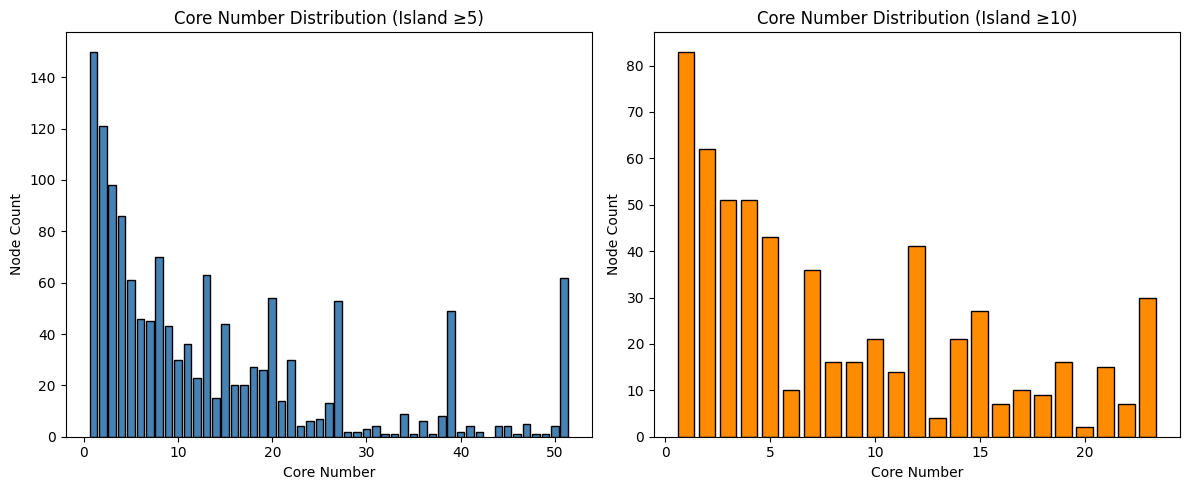

In [320]:

plt.figure(figsize=(12, 5))

# Histogram for Island ≥5
plt.subplot(1, 2, 1)
plt.bar(core_summary_top5["Core_Number"], core_summary_top5["Node_Count"],
        color="steelblue", edgecolor="black")
plt.title("Core Number Distribution (Island ≥5)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

# Histogram for Island ≥10
plt.subplot(1, 2, 2)
plt.bar(core_summary_top10["Core_Number"], core_summary_top10["Node_Count"],
        color="darkorange", edgecolor="black")
plt.title("Core Number Distribution (Island ≥10)")
plt.xlabel("Core Number")
plt.ylabel("Node Count")

plt.tight_layout()
plt.show()


The comparison of the two thresholds shows how the host network becomes more compact as weaker connections are removed. At a threshold of 5, the network has a highly cohesive core with 62 nodes and a core value of 51, reflecting strong overall connectivity. When the threshold increases to 10, both the core value and node count drop, forming a smaller but tightly linked cluster of 30 nodes with a core value of 23. This shift highlights how the network reorganizes around its strongest relationships as weaker ties disappear. The core analysis aligns with earlier results from the island and centrality metrics, confirming that the host network remains cohesive and resilient across thresholds, supported by a stable backbone of highly interconnected species.

#### Findings

Based on the analysis across thresholds, the host network shows a clear pattern of strong internal cohesion supported by a resilient core of key species. At lower thresholds, many hosts are connected through a wide web of weak and moderate ties, forming a large and highly cohesive structure. As weaker connections are removed, the network becomes smaller and more compact, yet it remains well connected through a stable inner group of hosts that share strong and consistent parasite relationships. This suggests that while many hosts contribute to the overall connectivity of the system, a smaller set of central species maintains its structural integrity. In other words, the host network is organized around a dense and stable backbone of highly interconnected species, indicating that these core hosts likely play a central role in sustaining parasite diversity and linking different parts of the ecological system.

## 3.2 Parasites


In [ ]:

parasite_graph = bipartite.weighted_projected_graph(GN,set(parasite_nodes))
weights_par = nx.get_edge_attributes(parasite_graph, 'weight')
max_weight_par = max(weights.values())

In [ ]:
plot_island_evolution(parasite_graph)

## Conclusion

Pending
